In [17]:
import requests
import urllib
import json
from urllib.parse import urlencode
import pandas as pd

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('dating_data.csv', 'wb') as f:
    f.write(download_response.content)
df = pd.read_csv('dating_data.csv')

In [18]:
df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [19]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [20]:
df.is_match.value_counts(normalize=True).mul(100)

0    66.632217
1    33.367783
Name: is_match, dtype: float64

Совпадения есть у 33% клиентов нашей выборки. Почему так мало? Есть ли различия в том, каким алгоритмом пользовались клиенты? Посмотрим частоту совпадений и несовпадений в группах по применению алгоритма.

In [21]:
pd.crosstab(df.group, df.is_match)

is_match,0,1
group,,
0,3858,934
1,5813,3909


Визуализируем соотношение match-ей в контрольной и тестовой группах и отметим явный рост в тестовой группе.

In [22]:
df1 = pd.read_csv('dating_data.csv')
df1['group']=df1['group'].apply(lambda x: 'test' if x==1 else 'control')
df1

,user_id_1,user_id_2,group,is_match
0,79,91,test,1
1,716,353,test,1
2,423,677,control,0
3,658,165,test,1
4,969,155,control,1
...,...,...,...,...
14509,476,631,control,0
14510,455,770,test,0
14511,260,6,test,1
14512,885,812,test,1


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [24]:
fig = px.histogram(df1[['group', 'is_match']], x='group', 
                   color='is_match')
fig.show()

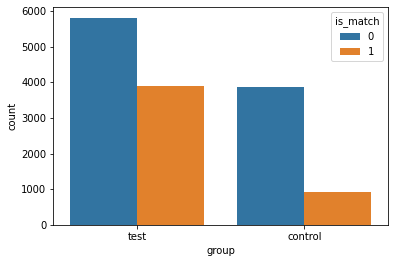

In [25]:
sns.countplot(data=df1, x="group", hue="is_match")

Совпадений в целом меньше. Но в приложении с новым алгоритмом существенно возросли match-и, и увеличился % match-ей. Случайность ли это проверим с помощью стат.теста.
H0 - совпадения случайны, рост % соотношения match-ей и не match-ей не зависит от алгоритма,
H1 - совпадения не случайны, рост % match-ей связан с обновлением алгоритма в приложении.
Переменные категориальные, применяем хи-квадрат.

In [26]:
import numpy as np
import scipy.stats as ss
import pingouin as pg

In [27]:
from scipy.stats import chi2_contingency, chi2

In [28]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.group, df.is_match))

In [29]:
stat, p

(618.6889141576198, 1.4418299163662586e-136)

p<0.05 => H0 можно отклонить, результат стат-ки значимый: рост % match-ей не случаен и связан с обновлением алгоритма в приложении. Но проверим еще такую прокси-метрику как число анкет (сколько пар приходится на каждого пользователя). Расчеты метрик приведены в результирующих df ниже.

In [35]:
df1_num0=df1.query('group=="control"').groupby('user_id_1', as_index=False).agg({'user_id_2':'count'})
df1_num0=df1_num0.rename(columns={'user_id_2':'num_form'})
df1_num0

,user_id_1,num_form
0,4,9
1,10,6
2,12,12
3,14,8
4,15,20
...,...,...
496,994,9
497,995,8
498,996,8
499,997,12


In [39]:
df1_num0.num_form.describe()

count    501.000000
mean       9.564870
std        3.056515
min        1.000000
25%        8.000000
50%        9.000000
75%       12.000000
max       20.000000
Name: num_form, dtype: float64

In [36]:
df1_num1=df1.query('group=="test"').groupby('user_id_1', as_index=False).agg({'user_id_2':'count'})
df1_num1=df1_num1.rename(columns={'user_id_2':'num_form'})
df1_num1

,user_id_1,num_form
0,1,24
1,2,16
2,3,16
3,5,22
4,6,22
...,...,...
494,987,23
495,992,21
496,993,18
497,998,18


In [40]:
df1_num1.num_form.describe()

count    499.000000
mean      19.482966
std        2.991489
min       11.000000
25%       18.000000
50%       20.000000
75%       22.000000
max       29.000000
Name: num_form, dtype: float64

Описательные статистики при беглом взгляде говорят о том, что средние значения кол-ва анкет на пользователя существенно отличаются (~10 на ~19). Визуализируем распределения, и видим, что они похоже на нормальные, и распределение кол-ва анкет в тестовой группе сдвинуто вправо по оси X и, подтверждает предположение о росте кол-ва анкет на пользователя в приложении с новым алгоритмом. Проверим это статистически:
H0 - различий в кол-ве анкет на пользователя в группах нет,
Н1 - различия есть.

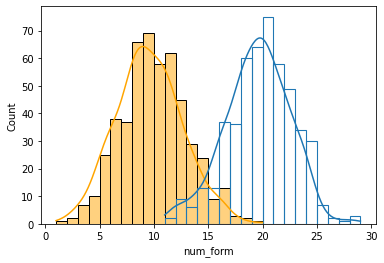

In [37]:
sns.histplot(df1_num0['num_form'], kde=True, color='orange')
sns.histplot(df1_num1['num_form'], kde=True, fill=False)

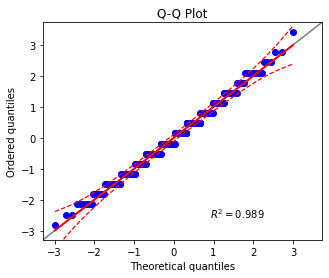

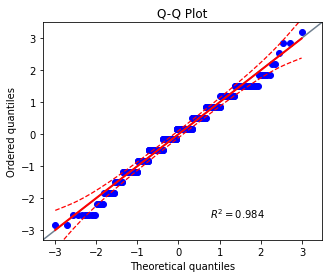

In [42]:
pg.qqplot(df1_num0['num_form'])
pg.qqplot(df1_num1['num_form'])

In [46]:
print(ss.normaltest(df1_num0['num_form']))
print(ss.normaltest(df1_num1['num_form']))

NormaltestResult(statistic=2.4061675155374465, pvalue=0.300266832562874)
NormaltestResult(statistic=4.262188990750171, pvalue=0.11870729813673236)


In [50]:
pg.normality(data=df1.groupby(['group','user_id_1'], as_index=False).agg({'user_id_2':'count'}), dv="user_id_2", group="group", method="normaltest")

,W,pval,normal
control,2.406168,0.300267,True
test,4.262189,0.118707,True


In [47]:
ss.levene(df1_num0['num_form'], df1_num1['num_form'])

LeveneResult(statistic=0.4804538582845789, pvalue=0.48837808141783545)

Тесты на нормальность распределений подтверждают, что мы имеем дело с нормально распределенными данными. Количества наблюдений в выборках достаточно, и гомогенность дисперсий в группах подтверждается => применяем классический t-тест.

In [48]:
ss.ttest_ind(df1_num0['num_form'], df1_num1['num_form'])

Ttest_indResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285)

p<0.05, полученный результат стат-ки значим, H0 отклоняется и применяется альтернативная гипотеза о наличии различий в метрике.
Кол-во анкет на пользователя увеличилось в тестовой версии. Включаем новую систему поиска анкет на всех пользователей.